In [28]:
import os
os.chdir('/Coding/CVPR2025_abaw_framewise/')

In [29]:
import pandas as pd
import csv, ffmpeg

data = []

with open('data_abaw/default-split/train.txt', 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split(',', 2)
        video_path, label, text = parts
        file_path = os.path.join(video_path, os.path.basename(video_path).removesuffix('.mp4'))
        data.append([file_path, label, text])

df = pd.DataFrame(data, columns=['file_path', 'id', 'text'])

df.head()

,file_path,id,text
0,82622/Visite_1/82622_Question_7_2024-11-05_15-...,1,This is a tough question. My girlfriend and I ...
1,82650/Visite_1/82650_Question_5_2024-11-13_00-...,0,I am willing to play Omi the card game every t...
2,82627/Visite_1/82627_Question_5_2024-11-06_11-...,1,I am almost always willing to go out to eat. S...
3,82708/Visite_1/82708_Question_7_2024-11-18_15-...,1,"I could have switched jobs by now, but I haven..."
4,82694/Visite_1/82694_Question_2_2024-11-15_21-...,1,I'm happy was a drinks major I would say I'm c...


In [30]:
df.iloc[0]['file_path']

'82622/Visite_1/82622_Question_7_2024-11-05_15-15-03_Video.mp4/82622_Question_7_2024-11-05_15-15-03_Video'

In [31]:
import yaml

sample = df.iloc[3]

yaml_path = os.path.join('/Coding/CVPR2025_abaw_framewise/data_abaw/transcription', sample['file_path'] + '.yml')
# print(yaml_path)
# print("/Coding/CVPR2025_abaw_framewise/data_abaw/transcription/82557/Visite 1/82557_Question_1_2024-08-22 14-46-11_Video.mp4/82557_Question_1_2024-08-22 14-46-11_Video.yml")

with open(yaml_path, 'r', encoding='utf-8') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)

one_yml_df = pd.DataFrame(data['chunks'])
one_yml_df


,language,text,timestamp
0,english,"I could have switched jobs by now, but I have...","(0.0, 9.56)"
1,english,and the uncertainty of a new job.,"(9.56, 11.68)"


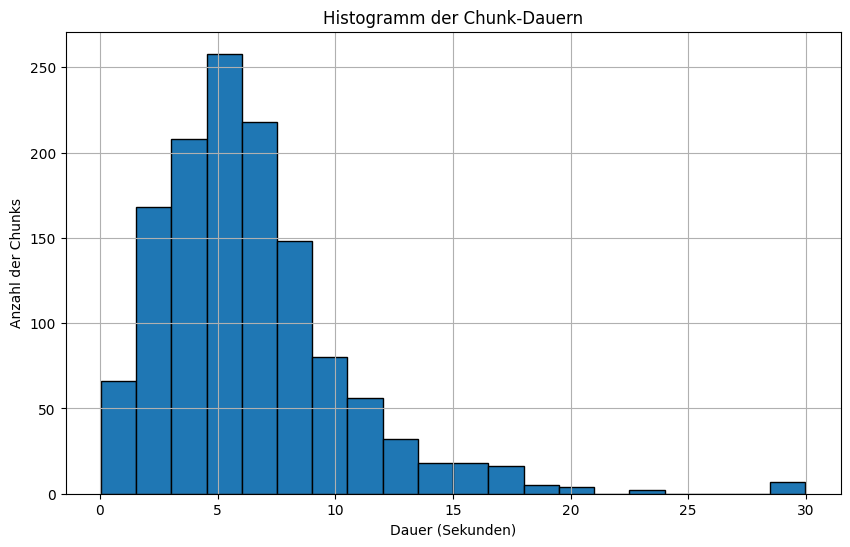

In [32]:
import matplotlib.pyplot as plt

durations = []

for _, sample in df.iterrows():
    yaml_path = os.path.join('/Coding/CVPR2025_abaw_framewise/data_abaw/transcription', sample['file_path'] + '.yml')
    with open(yaml_path, 'r', encoding='utf-8') as file:
        data = yaml.load(file, Loader=yaml.FullLoader)    
    chunks_df = pd.DataFrame(data.get('chunks', []))    
    chunks_df[['start_time', 'end_time']] = pd.DataFrame(chunks_df['timestamp'].tolist(), index=chunks_df.index)
    chunks_df = chunks_df.drop(columns=['timestamp'])
    
    chunks_df['duration'] = chunks_df['end_time'] - chunks_df['start_time']
    durations.extend(chunks_df['duration'].dropna())


# Erstellung des Histogramms, wenn Daten vorhanden sind
if durations:
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=20, edgecolor='black')
    plt.xlabel('Dauer (Sekunden)')
    plt.ylabel('Anzahl der Chunks')
    plt.title('Histogramm der Chunk-Dauern')
    plt.grid(True)
    plt.show()
else:
    print("Keine Chunk-Dauern zum Anzeigen vorhanden.")

In [33]:
text_df = one_yml_df

# Definiertes Sound-Intervall
sound_interval = (0.0, 10.0)

# Finden der Chunks, die vom Sound-Intervall betroffen sind
affected_chunks = text_df[
    (text_df['timestamp'].apply(lambda x: x[1] > sound_interval[0])) &
    (text_df['timestamp'].apply(lambda x: x[0] < sound_interval[1]))
]

# Extrahieren der Zeitstempel der betroffenen Chunks
time_stamps = affected_chunks['timestamp'].tolist()

# Extrahieren des Textes der betroffenen Chunks
texts = affected_chunks['text'].tolist()

print("Betroffene Zeitstempel:", time_stamps)
print("Betroffene Texte:", texts)

Betroffene Zeitstempel: [(0.0, 9.56), (9.56, 11.68)]
Betroffene Texte: [" I could have switched jobs by now, but I haven't done yet because I'm afraid of the possibilities", ' and the uncertainty of a new job.']


In [66]:
import numpy as np

time_stamps = [
    (0, 5),
    (4, 9),
    (11, 15),
    (14, 20),
    (18, 25),
    (30, 35)
]


sound_interval = (0,13)
time_midpoint = sound_interval[0] + (sound_interval[1] - sound_interval[0]) / 2

time_stamps_within_left = [ts for ts in time_stamps 
                            if (ts[0] <= sound_interval[0] and ts[1] > sound_interval[0])  
                            or (ts[0] > sound_interval[0]  and ts[0] < time_midpoint)
                            ]
time_stamps_within_right = [ts for ts in time_stamps 
                            if (ts[0] >= time_midpoint and ts[0] < sound_interval[1])  
                            or (ts[0] < time_midpoint  and ts[1] > time_midpoint)
                            ]

print(f"time_stamps_within_left within {sound_interval} -> split at {time_midpoint}: {time_stamps_within_left}")
print(f"time_stamps_within_left within {sound_interval} -> split at {time_midpoint}: {time_stamps_within_right}")

if time_stamps_within_left:
    redundant_time_left = np.sum([sound_interval[0] - ts[0] for ts in time_stamps_within_left if ts[0] < sound_interval[0]]) + np.sum([ts[1] - time_midpoint for ts in time_stamps_within_left if ts[1] > time_midpoint])
else:
    redundant_time_left = 1e3

if time_stamps_within_right:
    redundant_time_right = np.sum([time_midpoint - ts[0] for ts in time_stamps_within_right if ts[0] < time_midpoint])+ np.sum([ts[1] - sound_interval[1] for ts in time_stamps_within_right if ts[1] > sound_interval[1]])
else:
    redundant_time_right = 1e3


text_weight_a = (1/redundant_time_left) / (1/redundant_time_left + 1/redundant_time_right) 
text_weight_b = (1/redundant_time_right) / (1/redundant_time_left + 1/redundant_time_right) 

print(text_weight_a)
print(text_weight_b)

time_stamps_within_left within (0, 13) -> split at 6.5: [(0, 5), (4, 9)]
time_stamps_within_left within (0, 13) -> split at 6.5: [(4, 9), (11, 15)]
0.6428571428571429
0.3571428571428571
